In [1]:
using Flux
using MLDatasets
using Random

In [2]:
train_x, train_y = CIFAR10.traindata(Float32, 1:5000)
test_x, test_y = CIFAR10.testdata(Float32, 1:5000);

In [3]:
println("Size of each image: ", size(train_x))
println("Label of 50th training datapoint: ", train_y[50])
# So here we can see that each training point is a 3D array - a 32x32 image with 3 color channels

Size of each image: (32, 32, 3, 5000)
Label of 50th training datapoint: 0


In [4]:
# Since this is a multi-class classification problem, we can use one hot encoding, just like the MNIST dataset.
# There's 10 classes just like mnist, so we encode from 0 to 9

train_y, test_y = Flux.onehotbatch(train_y, 0:9), Flux.onehotbatch(test_y, 0:9)
nclasses = length(train_y[:,1])
println("number of classes: ", nclasses)

number of classes: 10


In [5]:
# 3 VGG Block
model_VGG3 = Chain(
              Conv((3,3), 3=>32, relu, pad=SamePad()),
              Conv((3,3), 32=>32, relu, pad=SamePad()),
              MaxPool((2,2)),
              Dropout(0.2),
              Conv((3,3), 32=>64, relu, pad=SamePad()),
              Conv((3,3), 64=>64, relu, pad=SamePad()),
              MaxPool((2,2)),
              Dropout(0.2),
              Conv((3,3), 64=>128, relu, pad=SamePad()),
              Conv((3,3), 128=>256, relu, pad=SamePad()),
              MaxPool((2,2)),
              Dropout(0.2),
              Flux.flatten,
              Dense(4096,128,relu),
              Dropout(0.2),
              Dense(128,10),
              softmax)

Chain(
  Conv((3, 3), 3 => 32, relu, pad=1),   # 896 parameters
  Conv((3, 3), 32 => 32, relu, pad=1),  # 9_248 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((3, 3), 32 => 64, relu, pad=1),  # 18_496 parameters
  Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  Conv((3, 3), 128 => 256, relu, pad=1),  # 295_168 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(4096, 128, relu),               # 524_416 parameters
  Dropout(0.2),
  Dense(128, 10),                       # 1_290 parameters
  NNlib.softmax,
)                   # Total: 16 arrays, 960_298 parameters, 3.666 MiB.

In [5]:
function loss_and_accuracy(udata, wdata, model)

    ndata = size(udata,4)

    ŵ = model(udata)
    loss = Flux.crossentropy(ŵ, wdata; agg=sum)
    accuracy = sum(Flux.onecold(ŵ) .== Flux.onecold(wdata)) / ndata
    return loss, accuracy
end

loss_and_accuracy (generic function with 1 method)

In [6]:
batch_size = 256
train_loader = Flux.Data.DataLoader((train_x, train_y), batchsize=batch_size, shuffle=true);

In [7]:
function train(model,train_loader,train_x,train_y,test_x,test_y,model_name)
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    opt = ADAM(0.001)
    K = 10
    for k in 1:K
        for (u, w) in train_loader
            gs = gradient(() -> Flux.Losses.crossentropy(model(u), w), Flux.params(model)) # compute gradient
            Flux.Optimise.update!(opt, Flux.params(model), gs) # update parameters
        end
        println("Epoch $k for $model_name architecture.")
        train_loss, train_acc = loss_and_accuracy(train_x, train_y,  model)

        test_loss, test_acc = loss_and_accuracy(test_x, test_y, model)

        println("  train_loss = $train_loss, train_accuracy = $train_acc")
        println("  test_loss = $test_loss, test_accuracy = $test_acc")
        
        push!(test_losses, test_loss)
        push!(test_accuracy, test_acc)
        push!(train_losses, train_loss)
        push!(train_accuracy, train_acc)
    end
    return train_losses, train_accuracy, test_losses, test_accuracy
end

train (generic function with 1 method)

In [ ]:
function to_model(vector)
    return Chain(
              Conv((3,3), 3=>32, relu, pad=SamePad(), 
              weight=reshape(vector[1:864],(3,3,3,32)), bias=vector[865:896]),
              Conv((3,3), 32=>32, relu, pad=SamePad(),
              weight=reshape(vector[897:10112],(3,3,32,32)), bias=vector[10112:10143]),
              MaxPool((2,2)),
              Dropout(0.2),
              Conv((3,3), 32=>64, relu, pad=SamePad(), weight=reshape(vector[10144:28575], 
              (3,3,32,64)), bias=vector[28575:28638]),
              Conv((3,3), 64=>64, relu, pad=SamePad(), weight=reshape(vector[28639:65502], 
              (3,3,64,64)), bias=vector[65503:65566]),
              MaxPool((2,2)),
              Dropout(0.2),
              Conv((3,3), 64=>128, relu, pad=SamePad(),weight=reshape(vector[65568:139295], 
              (3,3,64,128)), bias=vector[139296:139423]), 
              Conv((3,3), 128=>256, relu, pad=SamePad(),weight=reshape(vector[139424:434335], 
              (3,3,128,256)), bias=vector[434336:434591]),
              MaxPool((2,2)),
              Dropout(0.2),
              Flux.flatten,
              Dense(reshape(vector[434592:958879],(128,4096)),vector[958880:959007],relu),
              Dropout(0.2),
              Dense(reshape(vector[959008:960287], (10,128)),vector[960288:960297],relu))
end

In [ ]:
mutable struct Particle 
    position::Vector{Float32}
    best_position::Vector{Float32}
    best_accuracy::Float32
    velocity::Vector{Float32}
end

In [ ]:
# doesn't work, but can be made to work with a few changes. Since our project doesn't focus on training
# I left an unfinished variant of GPSO - PSO with gradient information
function train_PSO(model,train_loader,train_x,train_y,test_x,test_y, numparticles, ω, c1,c2)
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    particles = []
    best_loss, best_accuracy = loss_and_accuracy(train_x, train_y,  model)
    
    params = Flux.params(model)
    params_flattened = []
    
    for p in params
        flattened = flatten(p)
        final = reshape(flattened, (1, size(flattened, 1) * size(flattened,2)))
        append!(params_flattened, final)
    end
    
    swarm_best_position = params_flattened
    d = size(params_flattened)
    
    #init particles
    for n in 1:numparticles
        push!(particles, Particle(params_flattened,params_flattened,best_accuracy,rand(Float32,size(params_flattened))))
    end

    println("Initalized particles!")
    
    for k in 1:3
        # PSO
        for p in particles
            # vector math for additional speed boost
            # ω - inertia weight, how much the previous velocity impacts the current position
            # c1 - how much the particle pays attention to its own best position
            # c2 - how much the particle pays attention to the swarm's best position                
            r1 = rand((0.0:1.0))
            r2 = rand((0.0:1.0))
            p.velocity = (ω .* p.velocity) .+ r1 * c1 .* (p.best_position .- p.position)) .+ r2 * c2 .* (swarm_best_position .- p.position))
            # need to make sure that these values are always between 0 and 1
            p.position = clamp.(p.position .+ p.velocity,0.0,1.0)            
            moved_model = to_model(p.position)
            this_loss, this_acc = loss_and_accuracy(train_x,train_y, moved_model)
                if p.best_loss > this_loss
                    p.best_loss = this_loss
                    p.best_position = p.position
                    if best_loss > this_loss
                        best_loss = this_loss
                        swarm_best_position = p.position
                        model = moved_model
                        println("New loss: $this_loss")
                    end
                end
            end
        this_loss = 0
        this_acc = 0
        # Gradient Descent
        for (u, w) in train_loader
            gs = gradient(() -> Flux.Losses.crossentropy(model(u), w), Flux.params(model)) # compute gradient
            Flux.Optimise.update!(opt, Flux.params(model), gs) # update parameters
            this_loss, this_acc = loss_and_accuracy(train_x,train_y,model)
        end
        if this_loss < best_loss
            best_loss = this_loss
            params = Flux.params(model)
            new_params_flattened = []
            for p in params
                flattened = flatten(p)
                final = reshape(flattened, (1, size(flattened, 1) * size(flattened,2)))
                append!(new_params_flattened, final)
            end
            swarm_best_position = new_params_flattened
        end
    end

    train_loss, train_acc = loss_and_accuracy(train_x, train_y,  model)
    test_loss, test_acc = loss_and_accuracy(test_x, test_y, model)

    println("  train_loss = $train_loss, train_accuracy = $train_acc")
    println("  test_loss = $test_loss, test_accuracy = $test_acc")
    
    push!(test_losses, test_loss)
    push!(test_accuracy, test_acc)
    push!(train_losses, train_loss)
    push!(train_accuracy, train_acc)
    return train_losses, train_accuracy, test_losses, test_accuracy, model
end

In [15]:
vgg3_train_loss, 
vgg3_train_accuracy, 
vgg3_test_loss, 
vgg3_test_accuracy,trained_model = train_PSO(model_VGG3, train_loader, train_x, train_y,test_x, test_y, 10, 0.5, 0.3, 0.4);

LoadError: UndefVarError: model_VGG3 not defined

In [18]:
vgg3_train_loss, 
vgg3_train_accuracy, 
vgg3_test_loss, 
vgg3_test_accuracy = train(model_VGG3,train_loader,train_x, train_y,test_x, test_y, "VGG3");

Epoch 1 for VGG3 architecture.
  train_loss = 10371.574, train_accuracy = 0.2514
  test_loss = 10462.541, test_accuracy = 0.2362
Epoch 2 for VGG3 architecture.
  train_loss = 9591.054, train_accuracy = 0.2924
  test_loss = 9705.475, test_accuracy = 0.2916
Epoch 3 for VGG3 architecture.
  train_loss = 8782.425, train_accuracy = 0.3562
  test_loss = 8889.289, test_accuracy = 0.3546
Epoch 4 for VGG3 architecture.
  train_loss = 8356.078, train_accuracy = 0.3906
  test_loss = 8470.649, test_accuracy = 0.3936
Epoch 5 for VGG3 architecture.
  train_loss = 8143.3794, train_accuracy = 0.3972
  test_loss = 8323.222, test_accuracy = 0.3854
Epoch 6 for VGG3 architecture.
  train_loss = 7817.737, train_accuracy = 0.4188
  test_loss = 8108.6445, test_accuracy = 0.4092
Epoch 7 for VGG3 architecture.
  train_loss = 7298.4385, train_accuracy = 0.462
  test_loss = 7590.6416, test_accuracy = 0.4424
Epoch 8 for VGG3 architecture.
  train_loss = 7081.3613, train_accuracy = 0.4932
  test_loss = 7524.2646, 

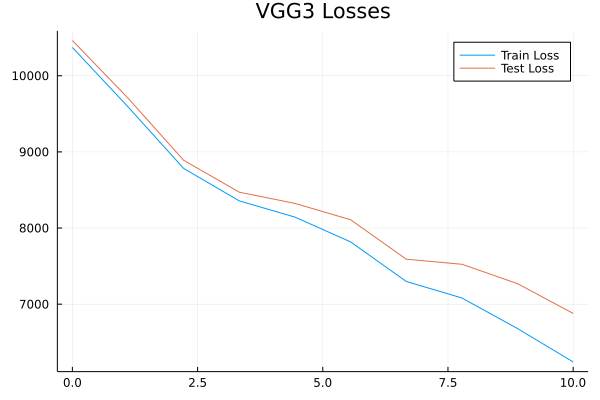

In [19]:
using Plots
plot(range(0, 10,length =10),vgg3_train_loss, labels="Train Loss")
plot!(range(0, 10,length =10),vgg3_test_loss, labels="Test Loss", title="VGG3 Losses",)

In [15]:
# PSO optimized model, 10 iterations
pso10_model = Chain(Conv((6,6), 3=>45, relu, pad=SamePad()),
    Conv((9,9), 45=>84, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Conv((7,7), 84=>87, relu, pad=SamePad()),
    Conv((4,4), 87=>92, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Conv((9,9), 92=>107, relu, pad=SamePad()),
    Conv((7,7), 107=>167, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Flux.flatten,
    Dense(2672,208,relu),
    Dropout(0.2),
    Dense(208,10),
    softmax)
#pso10_model(rand(Float32,32,32,3,10))

Chain(
  Conv((6, 6), 3 => 45, relu, pad=(3, 2, 3, 2)),  # 4_905 parameters
  Conv((9, 9), 45 => 84, relu, pad=4),  # 306_264 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((7, 7), 84 => 87, relu, pad=3),  # 358_179 parameters
  Conv((4, 4), 87 => 92, relu, pad=(2, 1, 2, 1)),  # 128_156 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((9, 9), 92 => 107, relu, pad=4),  # 797_471 parameters
  Conv((7, 7), 107 => 167, relu, pad=3),  # 875_748 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(2672, 208, relu),               # 555_984 parameters
  Dropout(0.2),
  Dense(208, 10),                       # 2_090 parameters
  NNlib.softmax,
)                   # Total: 16 arrays, 3_028_797 parameters, 11.557 MiB.

In [16]:
pso10_train_loss, 
pso10_train_accuracy, 
pso10_test_loss, 
pso10_test_accuracy = train(pso10_model,train_loader,train_x, train_y,test_x, test_y, "PSO10");

Epoch 1 for PSO10 architecture.
  train_loss = 11511.951, train_accuracy = 0.1038
  test_loss = 11513.101, test_accuracy = 0.0982
Epoch 2 for PSO10 architecture.
  train_loss = 11279.893, train_accuracy = 0.148
  test_loss = 11358.1875, test_accuracy = 0.1464
Epoch 3 for PSO10 architecture.
  train_loss = 11027.957, train_accuracy = 0.2122
  test_loss = 11041.33, test_accuracy = 0.211
Epoch 4 for PSO10 architecture.
  train_loss = 9742.552, train_accuracy = 0.249
  test_loss = 9835.8955, test_accuracy = 0.2418
Epoch 5 for PSO10 architecture.
  train_loss = 9437.725, train_accuracy = 0.286
  test_loss = 9565.068, test_accuracy = 0.2972
Epoch 6 for PSO10 architecture.
  train_loss = 9206.287, train_accuracy = 0.3222
  test_loss = 9302.898, test_accuracy = 0.3288
Epoch 7 for PSO10 architecture.
  train_loss = 8636.391, train_accuracy = 0.365
  test_loss = 8876.986, test_accuracy = 0.3442
Epoch 8 for PSO10 architecture.
  train_loss = 8139.3936, train_accuracy = 0.3902
  test_loss = 8354.9

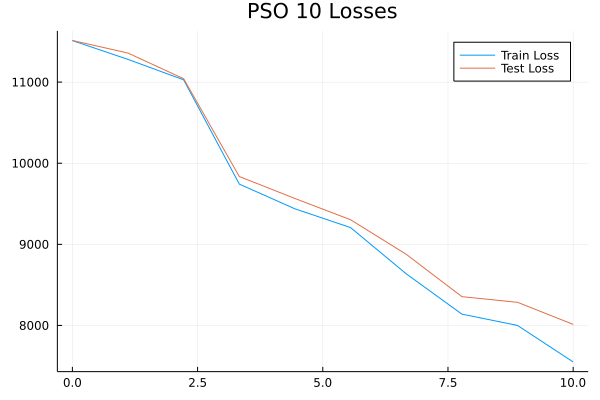

In [17]:
using Plots
plot(range(0, 10,length =10),pso10_train_loss, labels="Train Loss")
plot!(range(0, 10,length =10),pso10_test_loss, labels="Test Loss", title="PSO 10 Losses",)

In [8]:
pso10_modelb = Chain(Conv((2,2), 3=>43, relu, pad=SamePad()),
    Conv((2,2), 43=>54, relu, pad=SamePad()),
    MaxPool((4,4)),
    Dropout(0.2),
    Conv((5,5), 54=>64, relu, pad=SamePad()),
    Conv((3,3), 64=>229, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Conv((5,5), 229=>246, relu, pad=SamePad()),
    Conv((4,4), 246=>251, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Flux.flatten,
    Dense(1004,867,relu),
    Dropout(0.2),
    Dense(867,10),
    softmax) 
#3_505_296 parameters

Chain(
  Conv((2, 2), 3 => 43, relu, pad=(1, 0, 1, 0)),  # 559 parameters
  Conv((2, 2), 43 => 54, relu, pad=(1, 0, 1, 0)),  # 9_342 parameters
  MaxPool((4, 4)),
  Dropout(0.2),
  Conv((5, 5), 54 => 64, relu, pad=2),  # 86_464 parameters
  Conv((3, 3), 64 => 229, relu, pad=1),  # 132_133 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((5, 5), 229 => 246, relu, pad=2),  # 1_408_596 parameters
  Conv((4, 4), 246 => 251, relu, pad=(2, 1, 2, 1)),  # 988_187 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(1004, 867, relu),               # 871_335 parameters
  Dropout(0.2),
  Dense(867, 10),                       # 8_680 parameters
  NNlib.softmax,
)                   # Total: 16 arrays, 3_505_296 parameters, 13.374 MiB.

In [9]:
pso10b_train_loss, 
pso10b_train_accuracy, 
pso10b_test_loss, 
pso10b_test_accuracy = train(pso10_modelb,train_loader,train_x, train_y,test_x, test_y, "PSO10b");

Epoch 1 for PSO10b architecture.
  train_loss = 11347.293, train_accuracy = 0.1532
  test_loss = 11355.851, test_accuracy = 0.1444
Epoch 2 for PSO10b architecture.
  train_loss = 10445.81, train_accuracy = 0.2106
  test_loss = 10462.84, test_accuracy = 0.2048
Epoch 3 for PSO10b architecture.
  train_loss = 9258.15, train_accuracy = 0.2936
  test_loss = 9392.049, test_accuracy = 0.294
Epoch 4 for PSO10b architecture.
  train_loss = 8645.623, train_accuracy = 0.334
  test_loss = 8786.004, test_accuracy = 0.325
Epoch 5 for PSO10b architecture.
  train_loss = 8158.762, train_accuracy = 0.3706
  test_loss = 8350.213, test_accuracy = 0.3632
Epoch 6 for PSO10b architecture.
  train_loss = 7681.3643, train_accuracy = 0.4086
  test_loss = 7922.374, test_accuracy = 0.3934
Epoch 7 for PSO10b architecture.
  train_loss = 7515.537, train_accuracy = 0.4314
  test_loss = 7813.7197, test_accuracy = 0.4076
Epoch 8 for PSO10b architecture.
  train_loss = 7133.0625, train_accuracy = 0.4558
  test_loss = 

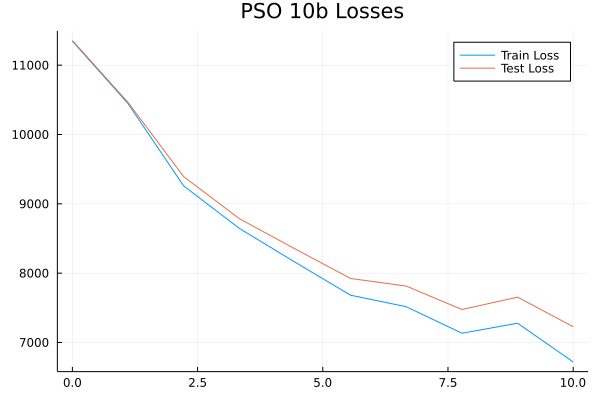

In [10]:
using Plots
plot(range(0, 10,length =10),pso10b_train_loss, labels="Train Loss")
plot!(range(0, 10,length =10),pso10b_test_loss, labels="Test Loss", title="PSO 10b Losses",)

In [13]:
pso20_model = Chain(Conv((4,4), 3=>29, relu, pad=SamePad()),
    Conv((2,2), 29=>65, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Conv((2,2), 65=>70, relu, pad=SamePad()),
    Conv((2,2), 70=>132, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Conv((6,6), 132=>142, relu, pad=SamePad()),
    Conv((2,2), 142=>211, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Flux.flatten,
    Dense(3376,253,relu),
    Dropout(0.2),
    Dense(253,10),
    softmax)

Chain(
  Conv((4, 4), 3 => 29, relu, pad=(2, 1, 2, 1)),  # 1_421 parameters
  Conv((2, 2), 29 => 65, relu, pad=(1, 0, 1, 0)),  # 7_605 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((2, 2), 65 => 70, relu, pad=(1, 0, 1, 0)),  # 18_270 parameters
  Conv((2, 2), 70 => 132, relu, pad=(1, 0, 1, 0)),  # 37_092 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((6, 6), 132 => 142, relu, pad=(3, 2, 3, 2)),  # 674_926 parameters
  Conv((2, 2), 142 => 211, relu, pad=(1, 0, 1, 0)),  # 120_059 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(3376, 253, relu),               # 854_381 parameters
  Dropout(0.2),
  Dense(253, 10),                       # 2_540 parameters
  NNlib.softmax,
)                   # Total: 16 arrays, 1_716_294 parameters, 6.550 MiB.

In [14]:
pso20_train_loss, 
pso20_train_accuracy, 
pso20_test_loss, 
pso20_test_accuracy = train(pso20_model,train_loader,train_x, train_y,test_x, test_y, "PSO20");

Epoch 1 for PSO20 architecture.
  train_loss = 11044.209, train_accuracy = 0.2292
  test_loss = 11046.568, test_accuracy = 0.2306
Epoch 2 for PSO20 architecture.
  train_loss = 9699.644, train_accuracy = 0.2942
  test_loss = 9863.288, test_accuracy = 0.2852
Epoch 3 for PSO20 architecture.
  train_loss = 9353.698, train_accuracy = 0.3122
  test_loss = 9461.38, test_accuracy = 0.3144
Epoch 4 for PSO20 architecture.
  train_loss = 8673.407, train_accuracy = 0.3608
  test_loss = 8779.116, test_accuracy = 0.3522
Epoch 5 for PSO20 architecture.
  train_loss = 8112.667, train_accuracy = 0.4134
  test_loss = 8345.672, test_accuracy = 0.3952
Epoch 6 for PSO20 architecture.
  train_loss = 7767.449, train_accuracy = 0.4312
  test_loss = 7970.5566, test_accuracy = 0.4168
Epoch 7 for PSO20 architecture.
  train_loss = 7684.3506, train_accuracy = 0.4454
  test_loss = 8008.452, test_accuracy = 0.4192
Epoch 8 for PSO20 architecture.
  train_loss = 7322.525, train_accuracy = 0.4672
  test_loss = 7810.5

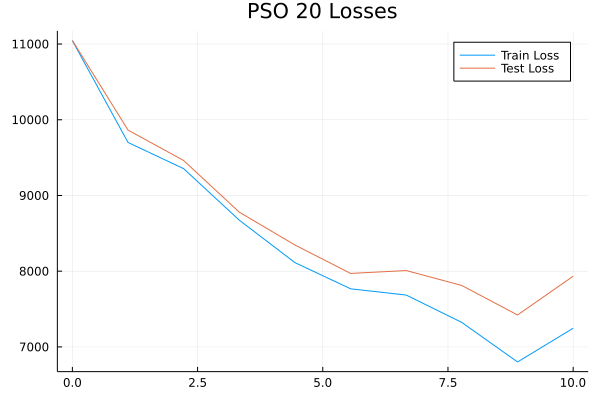

In [15]:
using Plots
plot(range(0, 10,length =10),pso20_train_loss, labels="Train Loss")
plot!(range(0, 10,length =10),pso20_test_loss, labels="Test Loss", title="PSO 20 Losses",)

In [14]:
pso10c_model = Chain(Conv((2,2), 3=>6, relu, pad=SamePad()),
    Conv((9,9), 6=>65, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Conv((2,2), 65=>69, relu, pad=SamePad()),
    Conv((8,8), 69=>116, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Conv((2,2), 116=>129, relu, pad=SamePad()),
    Conv((10,10),129=>169, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Flux.flatten,
    Dense(2704,833,relu),
    Dropout(0.2),
    Dense(833,10),
    softmax)

Chain(
  Conv((2, 2), 3 => 6, relu, pad=(1, 0, 1, 0)),  # 78 parameters
  Conv((9, 9), 6 => 65, relu, pad=4),   # 31_655 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((2, 2), 65 => 69, relu, pad=(1, 0, 1, 0)),  # 18_009 parameters
  Conv((8, 8), 69 => 116, relu, pad=(4, 3, 4, 3)),  # 512_372 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((2, 2), 116 => 129, relu, pad=(1, 0, 1, 0)),  # 59_985 parameters
  Conv((10, 10), 129 => 169, relu, pad=(5, 4, 5, 4)),  # 2_180_269 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(2704, 833, relu),               # 2_253_265 parameters
  Dropout(0.2),
  Dense(833, 10),                       # 8_340 parameters
  NNlib.softmax,
)                   # Total: 16 arrays, 5_063_973 parameters, 19.320 MiB.

In [15]:
pso10c_train_loss, 
pso10c_train_accuracy, 
pso10c_test_loss, 
pso10c_test_accuracy = train(pso10c_model,train_loader,train_x, train_y,test_x, test_y, "PSO10c");

Epoch 1 for PSO10c architecture.
  train_loss = 11227.121, train_accuracy = 0.1692
  test_loss = 11258.75, test_accuracy = 0.16
Epoch 2 for PSO10c architecture.
  train_loss = 9854.466, train_accuracy = 0.2748
  test_loss = 9945.164, test_accuracy = 0.2776
Epoch 3 for PSO10c architecture.
  train_loss = 9221.696, train_accuracy = 0.3146
  test_loss = 9364.428, test_accuracy = 0.312
Epoch 4 for PSO10c architecture.
  train_loss = 8746.697, train_accuracy = 0.37
  test_loss = 8956.471, test_accuracy = 0.362
Epoch 5 for PSO10c architecture.
  train_loss = 8154.295, train_accuracy = 0.399
  test_loss = 8465.432, test_accuracy = 0.385
Epoch 6 for PSO10c architecture.
  train_loss = 7834.329, train_accuracy = 0.4264
  test_loss = 8261.8125, test_accuracy = 0.397
Epoch 7 for PSO10c architecture.
  train_loss = 7498.609, train_accuracy = 0.4444
  test_loss = 7955.538, test_accuracy = 0.4112
Epoch 8 for PSO10c architecture.
  train_loss = 7414.5527, train_accuracy = 0.452
  test_loss = 8028.565

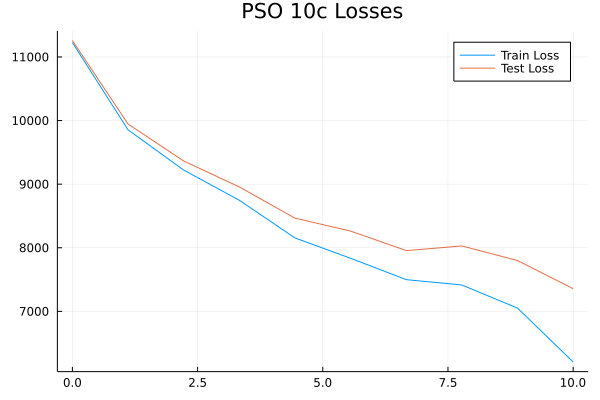

In [17]:
using Plots
plot(range(0, 10,length =10),pso10c_train_loss, labels="Train Loss")
plot!(range(0, 10,length =10),pso10c_test_loss, labels="Test Loss", title="PSO 10c Losses",)